In [ ]:
%reload_ext autoreload
%autoreload 2
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os, sys
import pickle
import re
from datetime import datetime
import shutil
from joblib import Parallel, delayed

from scipy.io import loadmat
from utils.data_io import extract_datetime, create_channel_map, get_sampling_rate
# Note: If importing fails, please restart the kernel to refresh the module.

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="2s", progress_bar=True)


SpikeInterface version: 0.103.2


In [ ]:
# Detect Kilosort folders and load sorting objects
stempath = glob.glob("V:\Sorting_comparison\Ryan\HP04\day_32_20240430")[0]

# Find all Kilosort folders that contain valid phy output
kilosort_folders = glob.glob(os.path.join(stempath, "*ilosort*"))

# Load sorting objects from each Kilosort folder that has phy output
sorting_objects = {}
for folder in kilosort_folders:
    phy_folder = folder  # Default: phy output is in the main folder
    
    # Check if spike_times.npy exists in the main folder
    if not os.path.exists(os.path.join(folder, 'spike_times.npy')):
        # Check if it exists in sorter_output subfolder
        sorter_output_path = os.path.join(folder, 'sorter_output')
        if os.path.exists(os.path.join(sorter_output_path, 'spike_times.npy')):
            phy_folder = sorter_output_path
    
    # Load the sorting object if phy output was found
    if os.path.exists(os.path.join(phy_folder, 'spike_times.npy')):
        sorting_name = os.path.basename(folder)
        try:
            sorting_objects[sorting_name] = se.read_phy(folder_path=Path(phy_folder), exclude_cluster_groups=['noise', 'mua'])
            print(f"Loaded: {sorting_name} (from {os.path.relpath(phy_folder, stempath)})")
        except Exception as e:
            print(f"Failed to load {sorting_name}: {e}")
    else:
        print(f"Skipping {os.path.basename(folder)} - no phy output found")

print(f"\nLoaded sorting objects: {list(sorting_objects.keys())}")


Loaded: Kilosort_2025-11-20_164231 (from Kilosort_2025-11-20_164231)
Loaded: Kilosort4_postprocess (from Kilosort4_postprocess)
Loaded: Kilosort4_after_artifact_removal_postprocess (from Kilosort4_after_artifact_removal_postprocess)
Failed to load Kilosort4_after_artifact_removal: name 'group' is not defined
Failed to load Kilosort4: name 'group' is not defined

Loaded sorting objects: ['Kilosort_2025-11-20_164231', 'Kilosort4_postprocess', 'Kilosort4_after_artifact_removal_postprocess']


Comparing 3 sorting objects: ['Kilosort_2025-11-20_164231', 'Kilosort4_postprocess', 'Kilosort4_after_artifact_removal_postprocess']
Multicomparison step 1: pairwise comparison
Multicomparison step 2: make graph
Multicomparison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


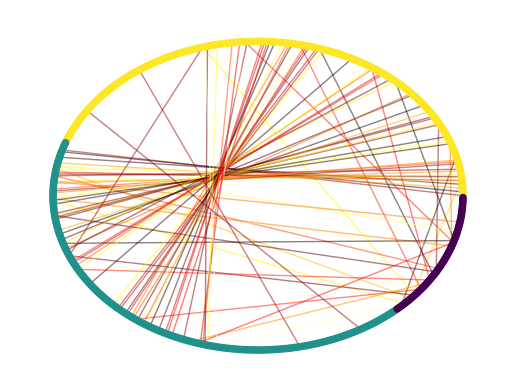

In [ ]:
import spikeinterface.comparison as scmp
import spikeinterface.widgets as sw

# Compare multiple sorting objects loaded
if len(sorting_objects) > 1:
    sorting_list = list(sorting_objects.values())
    name_list = list(sorting_objects.keys())
    
    print(f"Comparing {len(sorting_list)} sorting objects: {name_list}")
    
    mcmp = scmp.compare_multiple_sorters(
        sorting_list=sorting_list,
        name_list=name_list,
        verbose=True,
    )
    
    # グラフによる可視化
    sw.plot_multicomparison_graph(multi_comparison=mcmp)
else:
    print(f"Need at least 2 sorting objects for comparison. Found: {len(sorting_objects)}")


In [ ]:
agr_3 = mcmp.get_agreement_sorting(minimum_agreement_count=3)

In [ ]:
agr_3

AgreementSortingExtractor: 15 units - 1 segments - 20.0kHz